# imports

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, plot_roc_curve, classification_report
from math import exp
from IPython.display import HTML
import random


In [60]:
csv_url = 'https://github.com/automoto/big-five-data/blob/master/big_five_scores.csv'
df=pd.read_csv('big_five_scores.csv', index_col=0)

In [88]:

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# Exploratory Data Analysis

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307313 entries, 1 to 334161
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   country                  307141 non-null  object 
 1   age                      307313 non-null  int64  
 2   sex                      307313 non-null  int64  
 3   agreeable_score          307313 non-null  float64
 4   extraversion_score       307313 non-null  float64
 5   openness_score           307313 non-null  float64
 6   conscientiousness_score  307313 non-null  float64
 7   neuroticism_score        307313 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 21.1+ MB


In [62]:
NAN_rows = df.shape[0] - df.dropna().shape[0]
NAN_percent = NAN_rows/df.shape[0]
print(f"The amount of rows containig nan values is {(NAN_percent * 100):.2f}% ")

The amount of rows containig nan values is 0.06% 


Drop all nan values after review that there are less than 0.1%

In [63]:
data = df.dropna()

In [64]:
data.describe()

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score
count,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000
mean,25.193953,1.602557,0.696809,0.672328,0.733943,0.702013,0.574405
std,10.002145,0.489370,0.093565,0.108672,0.087612,0.107376,0.125743
min,10.000000,1.000000,0.200000,0.200000,0.253333,0.206667,0.196667
25%,18.000000,1.000000,0.640000,0.600000,0.673333,0.630000,0.486667
50%,22.000000,2.000000,0.703333,0.680000,0.736667,0.706667,0.570000
75%,29.000000,2.000000,0.763333,0.750000,0.796667,0.776667,0.660000
max,99.000000,2.000000,1.000000,0.993333,0.996667,1.000000,0.996667


In [65]:
gender_count = data['sex'].value_counts(normalize=True)
print(f"The data containes {(gender_count.iloc[0]*100):.2f}% female's surveys and {(gender_count.iloc[1]*100):.2f}% male's surveys")

The data containes 60.26% female's surveys and 39.74% male's surveys


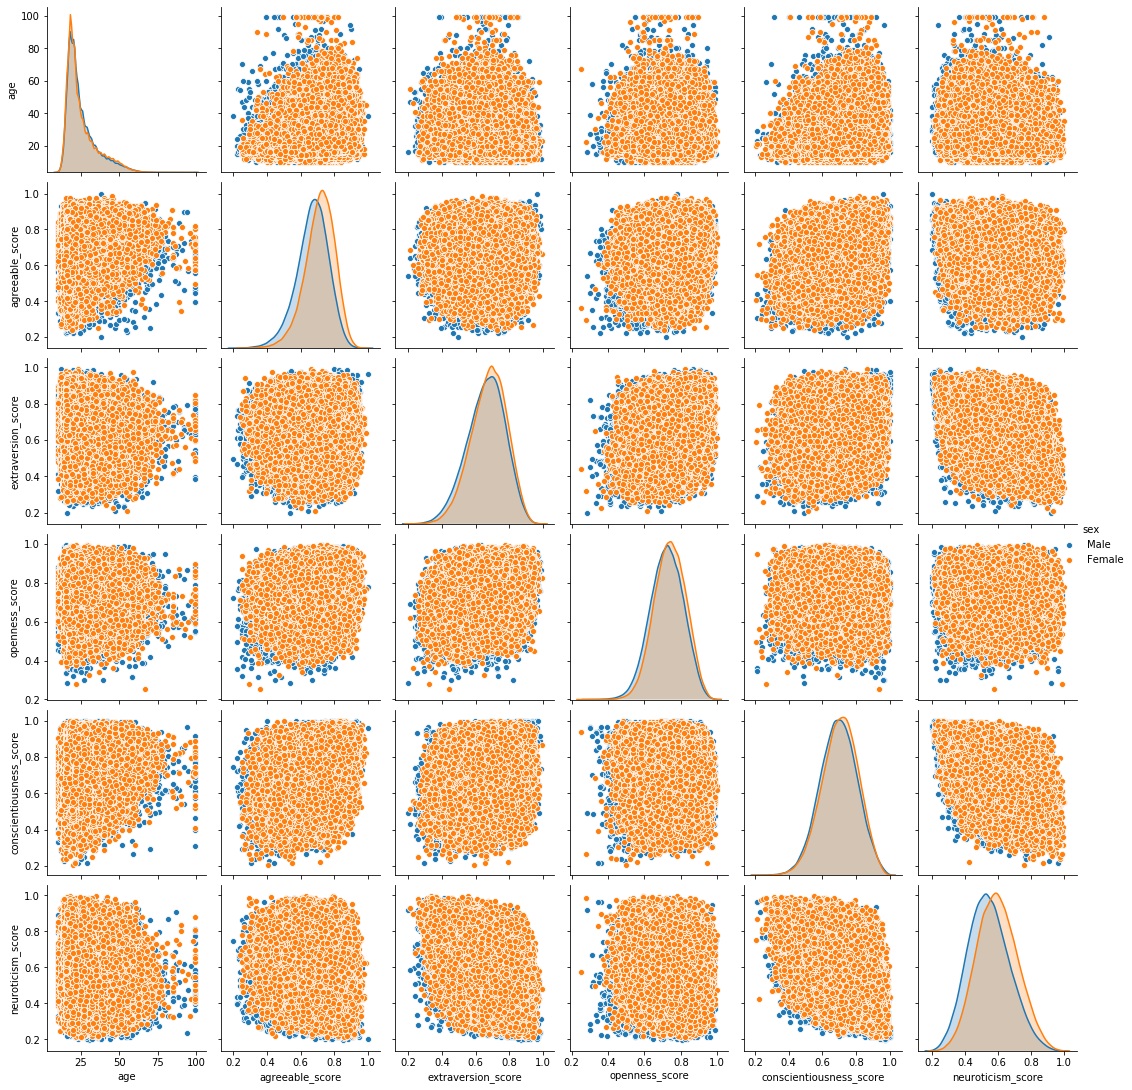

In [66]:
# g = sns.pairplot(data, hue='sex')
# new_labels = ['Male', 'Female']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# _=g

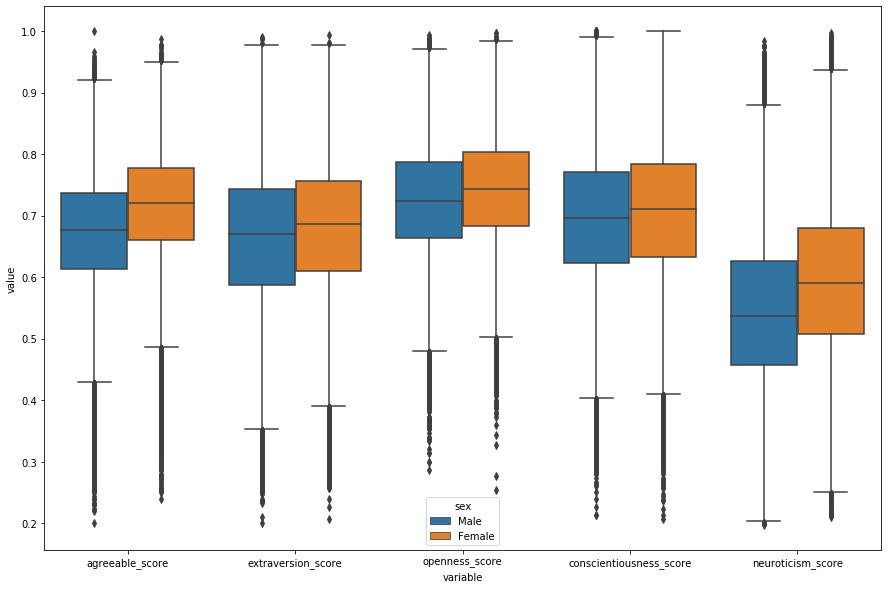

In [67]:
# personality_traits = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score','neuroticism_score']
# data1 = pd.melt(data, id_vars=['sex'], value_vars=personality_traits)
# data1.loc[(data1.sex == 1),'sex'] = 'Male'
# data1.loc[(data1.sex == 2),'sex'] = 'Female'
# fig, ax = plt.subplots(figsize = (15, 10))
# m = sns.boxplot(ax=ax, data=data1, x="variable", y="value", hue="sex")

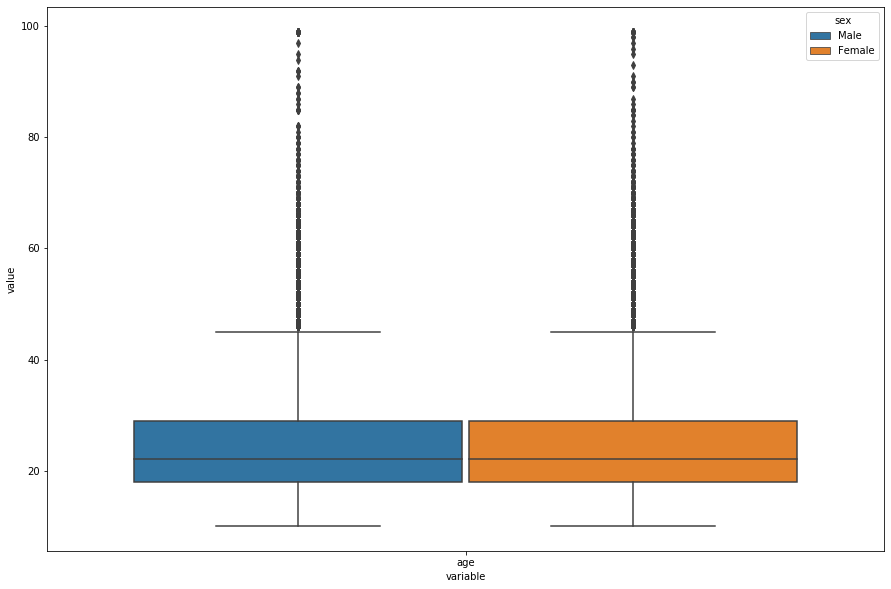

In [68]:
# data_age_melt = pd.melt(data, id_vars=['sex'], value_vars=['age'])
# data_age_melt.loc[(data_age_melt.sex == 1),'sex'] = 'Male'
# data_age_melt.loc[(data_age_melt.sex == 2),'sex'] = 'Female'
# fig, ax = plt.subplots(figsize = (15, 10))
# m = sns.boxplot(ax=ax, data=data_age_melt, x="variable", y="value", hue="sex")

How many countries are in the data


In [69]:
len(data.country.unique())

235

How many observations there are for each country in the data

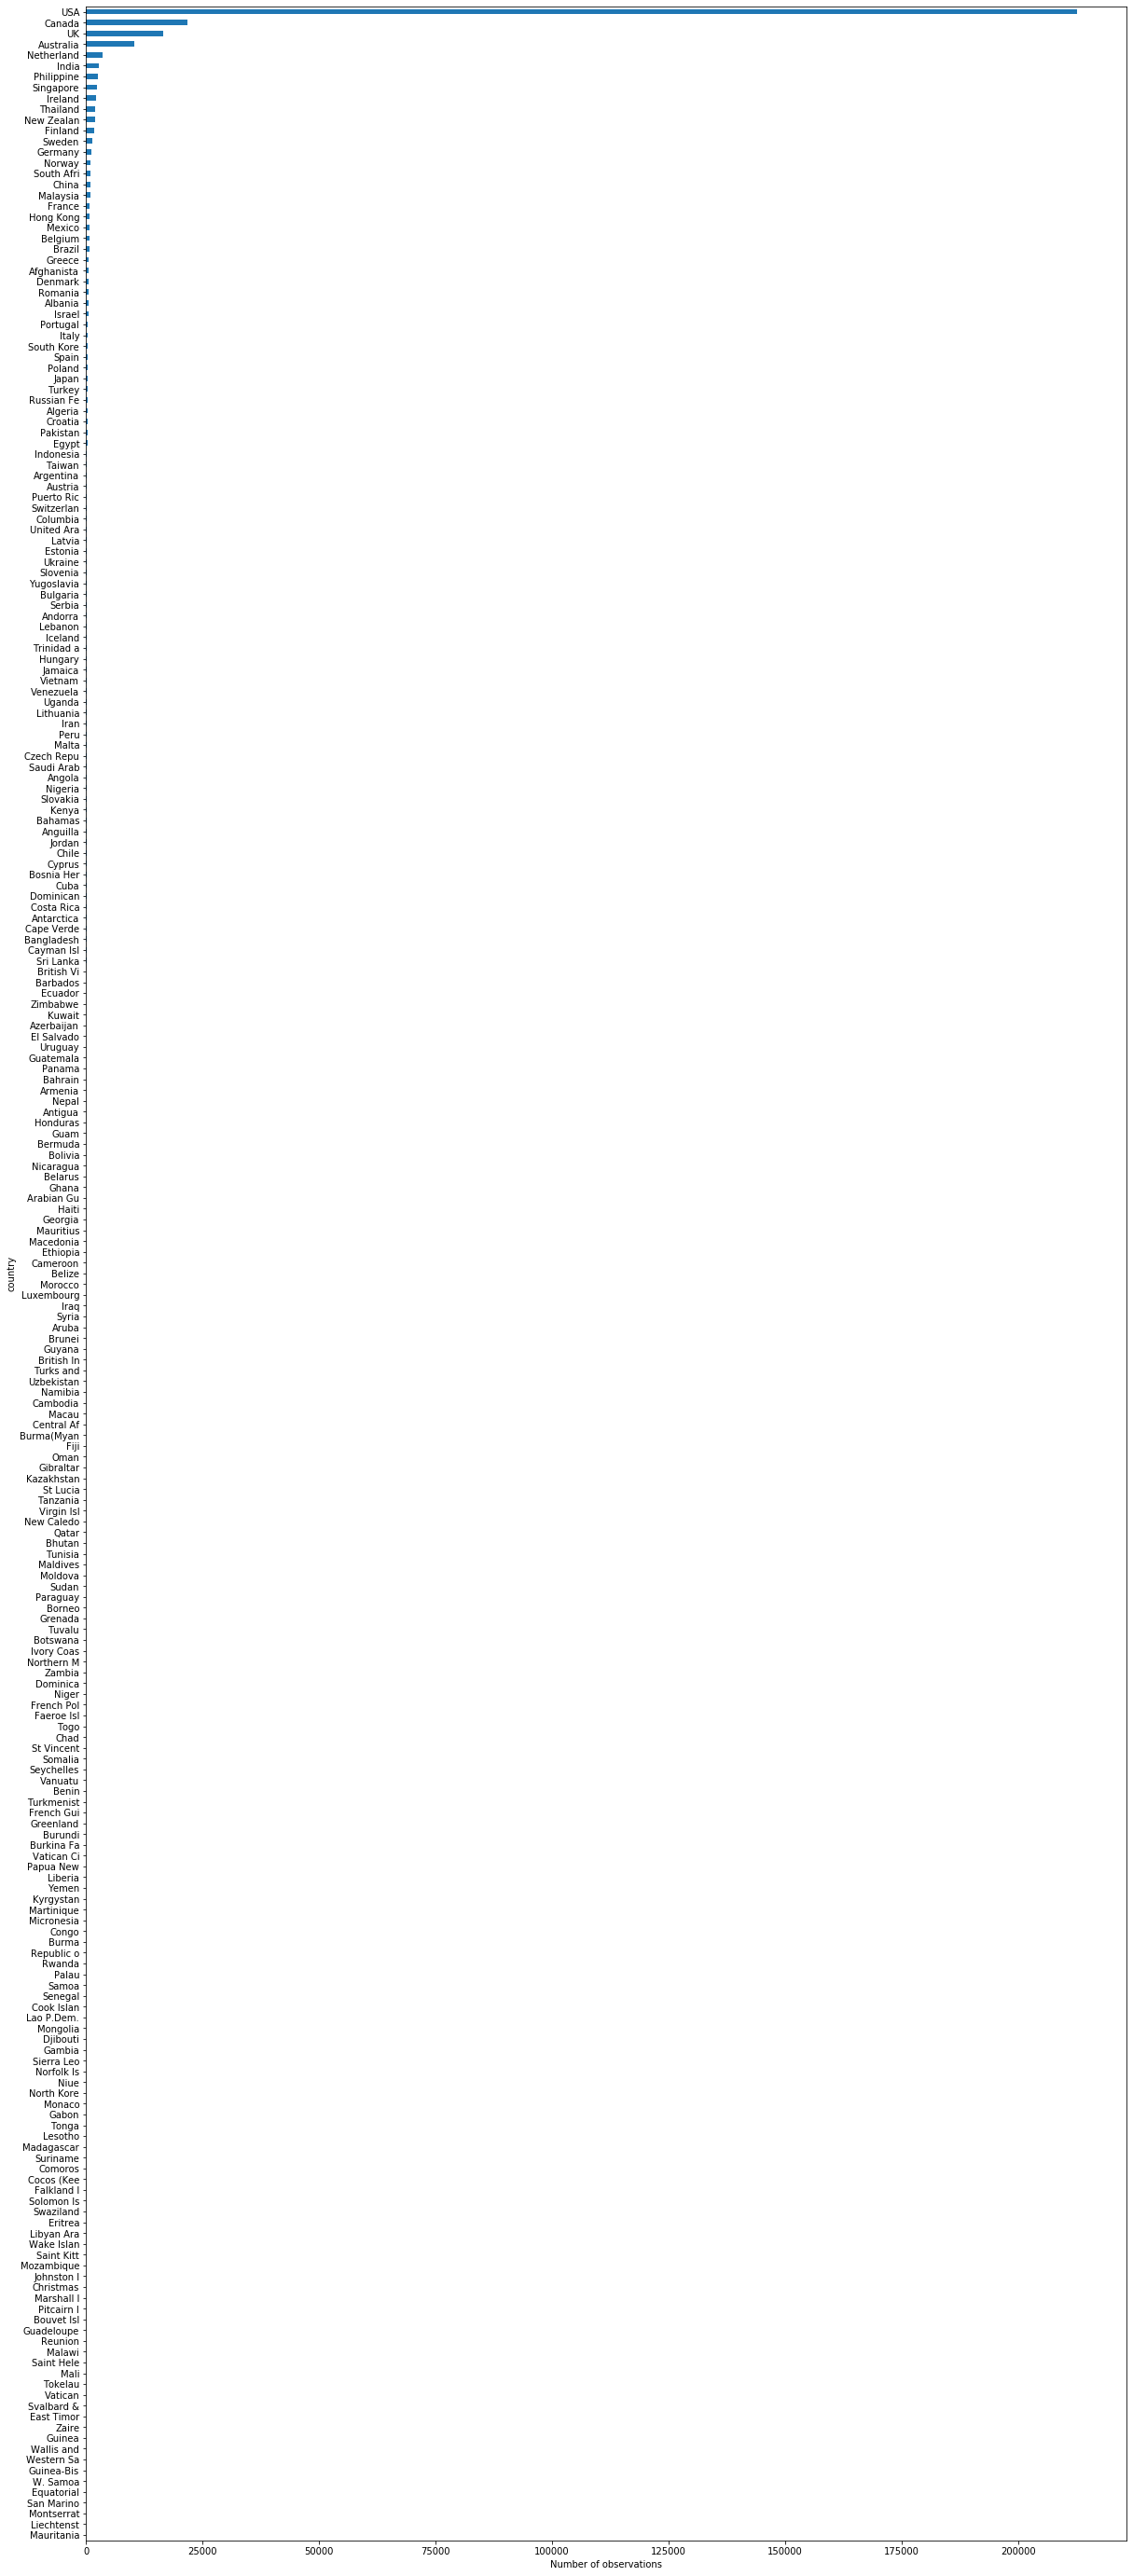

In [70]:
country = data.groupby(['country'])['age'].count().sort_values(ascending=True)
_=country.plot(kind='barh', figsize=(20,50))
_=plt.xlabel("Number of observations")

gender: more women than men - not balanced
age: not as in world's population 
countries: only 12 countries with more than 0.5% observations, and USA has a big advantage (69%)

# Preprocessing

according to the exploratory data analysis we decided to:
1. balance the data (gender)
2. use only observations from countries with significant amount of survey (more than 0.5%)

we decided to divide the process to three, using different data and comparing the results:
1. raw_data: the original data without NaN and only with significant countries encoding
2. balanced_data: raw_data downsampled to match populations' gender distribution
3. balanced_interacted_data: balanced_data with feature interaction

### raw data

In [ ]:
#Normalize features
scaler = MinMaxScaler()
names = data_country.columns
d = scaler.fit_transform(data_country)
scaled_data_country = pd.DataFrame(d, index=data_country.index, columns=names)
scaled_data_country

Narrow countries to only ones with more than significant percent of the data.


In [71]:
data_lenght = len(data)
significant_percent = 0.005
significant_observations = significant_percent * data_lenght
country[country > significant_observations]

country
Finland         1853
New Zealan      2016
Thailand        2059
Ireland         2102
Singapore       2450
Philippine      2488
India           2841
Netherland      3469
Australia      10400
UK             16489
Canada         21798
USA           212625
Name: age, dtype: int64

In [72]:
country_list = country[country > significant_observations].index.values.tolist()

Build Dataframes of chosen country binary variables and join with data 

In [73]:
countries = pd.get_dummies(data['country'][data['country'].isin(country_list)])
data_country = pd.concat([data, countries] ,axis=1)
data_country.insert(20, 'Other', np.where(np.isnan(data_country['UK'].values), 1, 0)) #add 'other' country column
raw_data = data_country.fillna(0).drop(['country'], axis=1)

In [74]:
raw_data

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score,Australia,Canada,Finland,India,Ireland,Netherland,New Zealan,Philippine,Singapore,Thailand,UK,USA,Other
case_id,,,,,,,,,,,,,,,,,,,,
1,24,1,0.753333,0.496667,0.803333,0.886667,0.426667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,24,2,0.733333,0.680000,0.786667,0.746667,0.590000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,36,2,0.880000,0.770000,0.860000,0.896667,0.296667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
5,19,1,0.690000,0.616667,0.716667,0.636667,0.563333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
6,17,1,0.600000,0.713333,0.646667,0.633333,0.513333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334156,22,2,0.750000,0.556667,0.733333,0.766667,0.643333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
334157,22,1,0.600000,0.620000,0.566667,0.650000,0.586667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
334158,22,2,0.820000,0.716667,0.753333,0.723333,0.526667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


### spliting the data to train and test 

In [75]:
target_name = 'sex'
raw_train, raw_test = train_test_split(raw_data)

In [76]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230355 entries, 103412 to 36167
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      230355 non-null  int64  
 1   sex                      230355 non-null  int64  
 2   agreeable_score          230355 non-null  float64
 3   extraversion_score       230355 non-null  float64
 4   openness_score           230355 non-null  float64
 5   conscientiousness_score  230355 non-null  float64
 6   neuroticism_score        230355 non-null  float64
 7   Australia                230355 non-null  float64
 8   Canada                   230355 non-null  float64
 9   Finland                  230355 non-null  float64
 10  India                    230355 non-null  float64
 11  Ireland                  230355 non-null  float64
 12  Netherland               230355 non-null  float64
 13  New Zealan               230355 non-null  float64
 14  

In [77]:
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76786 entries, 308053 to 304952
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      76786 non-null  int64  
 1   sex                      76786 non-null  int64  
 2   agreeable_score          76786 non-null  float64
 3   extraversion_score       76786 non-null  float64
 4   openness_score           76786 non-null  float64
 5   conscientiousness_score  76786 non-null  float64
 6   neuroticism_score        76786 non-null  float64
 7   Australia                76786 non-null  float64
 8   Canada                   76786 non-null  float64
 9   Finland                  76786 non-null  float64
 10  India                    76786 non-null  float64
 11  Ireland                  76786 non-null  float64
 12  Netherland               76786 non-null  float64
 13  New Zealan               76786 non-null  float64
 14  Philippine      

### balanced_data

there are 50.5% men i the world, and 49.5% females in the world (https://countrymeters.info/en/World) The original data containes 60.26% female's surveys and 39.74% male's surveys we'll try to oversample and undersample our data

In [78]:
minority_class = raw_train['sex'].value_counts()[1]
print(f"The data containes {(raw_train['sex'].value_counts()[2])} female's surveys and {(raw_train['sex'].value_counts()[1])} male's surveys")

The data containes 138728 female's surveys and 91627 male's surveys


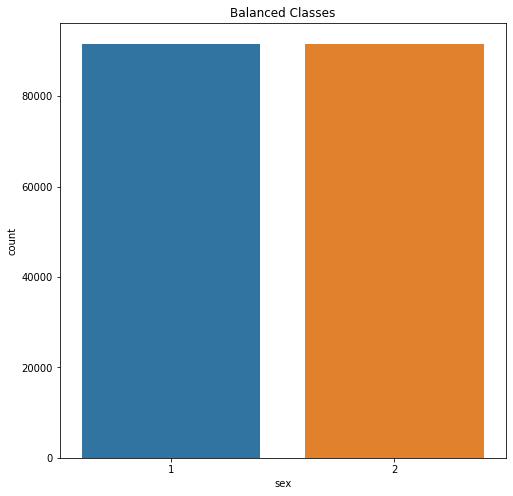

In [79]:
# Shuffle the Dataset.
shuffled_df = raw_train.sample(frac=1,random_state=4)

# Put all the male class in a separate dataset.
male_df = shuffled_df.loc[shuffled_df['sex'] == 1] #1= male, 2= female

#Randomly select minority_class number observations from the female (majority class)
female_df = shuffled_df.loc[shuffled_df['sex'] == 2].sample(n=minority_class,random_state=42)

# Concatenate both dataframes again
balanced_train = pd.concat([male_df, female_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('sex', data=balanced_train)
plt.title('Balanced Classes')
plt.show()

### balanced_interacted_data

add interactions columns of personality traits

In [80]:
Personality_Traits_list = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score', 'neuroticism_score']


In [81]:
balanced_interacted_train = balanced_train.copy()
balanced_interacted_train['agreeable_score*extraversion_score'] = balanced_interacted_train.agreeable_score * balanced_interacted_train.extraversion_score  
balanced_interacted_train['agreeable_score*conscientiousness_score'] = balanced_interacted_train.agreeable_score * balanced_interacted_train.conscientiousness_score  
balanced_interacted_train['conscientiousness_score*extraversion_score'] = balanced_interacted_train.conscientiousness_score * balanced_interacted_train.extraversion_score  
balanced_interacted_train['agreeable_score*neuroticism_score'] = balanced_interacted_train.agreeable_score * balanced_interacted_train.neuroticism_score  
balanced_interacted_train['agreeable_score*openness_score'] = balanced_interacted_train.agreeable_score * balanced_interacted_train.openness_score  
balanced_interacted_train

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score,Australia,Canada,Finland,...,Singapore,Thailand,UK,USA,Other,agreeable_score*extraversion_score,agreeable_score*conscientiousness_score,conscientiousness_score*extraversion_score,agreeable_score*neuroticism_score,agreeable_score*openness_score
case_id,,,,,,,,,,,,,,,,,,,,,
131273,17,1,0.546667,0.670000,0.653333,0.600000,0.613333,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.366267,0.328000,0.402000,0.335289,0.357156
303957,43,1,0.743333,0.716667,0.730000,0.850000,0.433333,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0,0.532722,0.631833,0.609167,0.322111,0.542633
77722,18,1,0.526667,0.703333,0.800000,0.453333,0.693333,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.370422,0.238756,0.318844,0.365156,0.421333
173177,14,1,0.833333,0.746667,0.800000,0.870000,0.556667,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.622222,0.725000,0.649600,0.463889,0.666667
74618,14,1,0.563333,0.966667,0.710000,0.706667,0.476667,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.544556,0.398089,0.683111,0.268522,0.399967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297444,20,2,0.670000,0.726667,0.786667,0.783333,0.616667,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0.486867,0.524833,0.569222,0.413167,0.527067
82594,14,2,0.763333,0.806667,0.686667,0.610000,0.593333,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.615756,0.465633,0.492067,0.452911,0.524156
63406,29,2,0.740000,0.820000,0.773333,0.826667,0.396667,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,0.606800,0.611733,0.677867,0.293533,0.572267


In [82]:
balanced_interacted_test = balanced_test.copy()
balanced_interacted_test['agreeable_score*extraversion_score'] = balanced_interacted_test.agreeable_score * balanced_interacted_test.extraversion_score  
balanced_interacted_test['agreeable_score*conscientiousness_score'] = balanced_interacted_test.agreeable_score * balanced_interacted_test.conscientiousness_score  
balanced_interacted_test['conscientiousness_score*extraversion_score'] = balanced_interacted_test.conscientiousness_score * balanced_interacted_test.extraversion_score  
balanced_interacted_test['agreeable_score*neuroticism_score'] = balanced_interacted_test.agreeable_score * balanced_interacted_test.neuroticism_score  
balanced_interacted_test['agreeable_score*openness_score'] = balanced_interacted_test.agreeable_score * balanced_interacted_test.openness_score  
balanced_interacted_test

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score,Australia,Canada,Finland,India,Ireland,Netherland,New Zealan,Philippine,Singapore,Thailand,UK,USA,Other
case_id,,,,,,,,,,,,,,,,,,,,
131273,17,1,0.546667,0.670000,0.653333,0.600000,0.613333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
303957,43,1,0.743333,0.716667,0.730000,0.850000,0.433333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
77722,18,1,0.526667,0.703333,0.800000,0.453333,0.693333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
173177,14,1,0.833333,0.746667,0.800000,0.870000,0.556667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
74618,14,1,0.563333,0.966667,0.710000,0.706667,0.476667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297444,20,2,0.670000,0.726667,0.786667,0.783333,0.616667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
82594,14,2,0.763333,0.806667,0.686667,0.610000,0.593333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
63406,29,2,0.740000,0.820000,0.773333,0.826667,0.396667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [83]:
datasets = ['raw_data', 'balanced_data', 'balanced_interacted_data']

in the preprocessing we also tried:
K-Mean, outliers handeling and PCA
but eventually decided not to use them, it didn't help the prediction

In [ ]:
Personality_Traits_list = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score', 'neuroticism_score']

In [ ]:
def pca_plot(data: pd.DataFrame, features: list, color_col: str ="sex"):
    """
    Plots the PCA as desired. 

    Parameters
    ---------
    data: pd.DataFrame
    features: list
        Features's list that we would like to reduce dimension
    ax_i: plt.axes
    color_col: str
        name of column to color the dots by.
    """
    x_only = data_country[features]

    pca_model = make_pipeline(StandardScaler(), PCA(n_components=2))
    pca_model.fit(x_only)

    X_2D = pca_model.transform(x_only)
    pca_dict = dict(PCA1=X_2D[:, 0], PCA2=X_2D[:, 1])
    pca_results = pd.DataFrame(pca_dict)

    color_series = data.loc[:, (color_col)].reset_index(drop=True)

    pca_results["color"] = color_series

    g = sns.scatterplot(data=pca_results, x="PCA1", y="PCA2", hue="color")
    g.legend_.remove()
    g.set(title=f"PCA of {features} colored by {color_col}")

In [ ]:
_=pca_plot(data_country, Personality_Traits_list)

In [87]:
#PCA

In [ ]:
#Kmeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
Kmeans = KMeans(n_clusters=3)
Kmeans.fit(scaled_data_country[personality_traits])
y_km = Kmeans.fit_predict(scaled_data_country[personality_traits])
new_series = pd.Series(y_km, index=scaled_data_country.index, name='cluster')
scaled_data_country_Kmeans = pd.concat([scaled_data_country, new_series] ,axis=1)

In [ ]:
scaled_data_country_Kmeans

In [ ]:
scaled_data_country_Kmeans.groupby(by=["cluster", "sex"]).median()

In [ ]:
scaled_data_country_Kmeans.groupby(by=["cluster", "sex"]).count()

In [ ]:
scaled_data_country_Kmeans.groupby(by=["cluster", "sex"]).mean()

In [ ]:
scaled_data_country_Kmeans.groupby(by=["cluster", "sex"]).sum()

# Models

we tried few models (Logistic regression, Linear regression, Decision trees, Gradient Boosting).
the best results were given by Logistic regression and  Gradient Boosting, we will show them here:

In [ ]:
for data in dataset:
    #vfgf